In [1]:
#load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import seaborn as sns

#classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

#evaluation metrics
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score #classification
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression

#skopt functions
import pprint
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from time import time

In [2]:
#load dataflight_delays_
file_path = ('C:/Users/pleaz/Desktop/Kaggle/Flight_Delay')

train_set = pd.read_csv(os.path.join(file_path, 'flight_delays_train.csv'))
test_set = pd.read_csv(os.path.join(file_path, 'flight_delays_test.csv'))

#copy each
train_df = train_set.copy()
test_df = test_set.copy()

In [3]:
train_set.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test_set.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [5]:
test_set['dep_delayed_15min'] = 0

dataset = pd.concat([train_set,test_set], axis = 0)

In [6]:
dataset.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
dataset['dep_delayed_15min'].describe()

count     200000
unique         3
top            0
freq      100000
Name: dep_delayed_15min, dtype: int64

In [8]:
dataset['DayOfWeek'].unique()

#remove c string in date columns

dataset['Month'] = dataset['Month'].str.replace(r'\D', '').astype(int)
dataset['DayofMonth'] = dataset['DayofMonth'].str.replace(r'\D', '').astype(int)
dataset['DayOfWeek'] = dataset['DayOfWeek'].str.replace(r'\D', '').astype(int)
dataset['Month'].unique()

array([ 8,  4,  9, 11, 10,  1,  7,  6,  5,  3, 12,  2])

In [9]:
dataset['UniqueCarrier'].unique()

array(['AA', 'US', 'XE', 'OO', 'WN', 'NW', 'DL', 'OH', 'AS', 'UA', 'MQ',
       'CO', 'EV', 'DH', 'YV', 'F9', 'AQ', 'TZ', 'HP', 'B6', 'FL', 'HA',
       '9E'], dtype=object)

# EDA

In [10]:
#explore structure
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              200000 non-null  int32 
 1   DayofMonth         200000 non-null  int32 
 2   DayOfWeek          200000 non-null  int32 
 3   DepTime            200000 non-null  int64 
 4   UniqueCarrier      200000 non-null  object
 5   Origin             200000 non-null  object
 6   Dest               200000 non-null  object
 7   Distance           200000 non-null  int64 
 8   dep_delayed_15min  200000 non-null  object
dtypes: int32(3), int64(2), object(4)
memory usage: 13.0+ MB


In [11]:
#simple eda - creates externally created report for EDA
# import dtale
# dtale.show(dataset)

# Feature Engineering

In [12]:
#route
dataset['Route'] = dataset['Origin'] + dataset['Dest']

In [13]:
#create unqiueCarrier
dataset['UniqueCarrier_Origin'] = dataset['UniqueCarrier'] + "_" + dataset['Origin']
dataset['UniqueCarrier_Dest'] = dataset['UniqueCarrier'] + "_" + dataset['Dest']

In [14]:
#season
dataset['summer'] = (dataset['Month'].isin([6, 7, 8]))
dataset['autumn'] = (dataset['Month'].isin([9, 10, 11]))
dataset['winter'] = (dataset['Month'].isin([12, 1, 2]))
dataset['spring'] = (dataset['Month'].isin([3, 4, 5]))

In [15]:
#hour and minute of the day
dataset['hour'] = dataset['DepTime'] // 100
dataset.loc[dataset['hour'] == 24, 'hour'] = 0
dataset.loc[dataset['hour'] == 25, 'hour'] = 1
dataset['minute'] = dataset['DepTime'] % 100

In [16]:
# give more importance to hour variable
dataset['hour_sq'] = dataset['hour'] ** 2
dataset['hour_sq2'] = dataset['hour'] ** 4

In [17]:
#weekends - create new column to indicate if the day of the week is on the weekend
dataset['is_weekend'] = (dataset['DayOfWeek'] == 6) | (dataset['DayOfWeek'] == 7)

In [18]:
#Distance
dataset['Dist_bin'] = 0
dataset.loc[dataset.Distance <= 500 , 'Dist_bin'] = 'vshort'
dataset.loc[(dataset.Distance > 500) & (dataset.Distance <= 1000), 'Dist_bin'] = 'short'
dataset.loc[(dataset.Distance > 1000) & (dataset.Distance <= 1500), 'Dist_bin'] = 'mid'
dataset.loc[(dataset.Distance > 1500) & (dataset.Distance <= 2000), 'Dist_bin'] = 'midlong'
dataset.loc[(dataset.Distance > 2000) & (dataset.Distance <= 2500), 'Dist_bin'] = 'long'
dataset.loc[dataset.Distance > 2500, 'Dist_bin'] = 'vlong'
dataset = dataset.drop(['Distance'], axis=1)

In [19]:
#departure time of the day (e.g. afternoon etc.)
dataset.loc[dataset.DepTime <= 600 , 'DepTime_bin'] = 'Night'
dataset.loc[(dataset.DepTime > 600) & (dataset.DepTime <= 1200), 'DepTime_bin'] = 'Morning'
dataset.loc[(dataset.DepTime > 1200) & (dataset.DepTime <= 1800), 'DepTime_bin'] = 'Afternoon'
dataset.loc[(dataset.DepTime > 1800) & (dataset.DepTime <= 2600), 'DepTime_bin'] = 'Evening' #since hours go over 24 (indicating early mornings?)

In [20]:
dataset['DayTime'] = 0
dataset.loc[dataset.DepTime <= 600 , 'DepTime_bin'] = 'Night'
dataset.loc[(dataset.DepTime > 600) & (dataset.DepTime <= 1200), 'DepTime_bin'] = 'Morning'
dataset.loc[(dataset.DepTime > 1200) & (dataset.DepTime <= 1800), 'DepTime_bin'] = 'Afternoon'
dataset.loc[(dataset.DepTime > 1800) & (dataset.DepTime <= 2600), 'DepTime_bin'] = 'Evening'

In [21]:
dataset['DepTime_bin'] = 0
dataset.loc[dataset.DepTime <= 600 , 'DepTime_bin'] = 'vem'
dataset.loc[(dataset.DepTime > 600) & (dataset.DepTime <= 900), 'DepTime_bin'] = 'm'
dataset.loc[(dataset.DepTime > 900) & (dataset.DepTime <= 1200), 'DepTime_bin'] = 'mm'
dataset.loc[(dataset.DepTime > 1200) & (dataset.DepTime <= 1500), 'DepTime_bin'] = 'maf'
dataset.loc[(dataset.DepTime > 1500) & (dataset.DepTime <= 1800), 'DepTime_bin'] = 'af'
dataset.loc[(dataset.DepTime > 1800) & (dataset.DepTime <= 2100), 'DepTime_bin'] = 'n'
dataset.loc[(dataset.DepTime > 2100) & (dataset.DepTime <= 2400), 'DepTime_bin'] = 'nn'
dataset.loc[dataset.DepTime > 2400, 'DepTime_bin'] = 'lm'
dataset = dataset.drop(['DepTime'], axis=1)

In [22]:
#region of departure and destination

#load dataset for airports
airports = pd.read_csv(os.path.join(file_path, 'airports.csv'))
#drop irrelevant rows (e.g. airports without IATA Code)
airports.dropna(subset = ['iata_code'], inplace = True)
#drop irrelevant columns
airports = airports.drop(['id','ident','name','latitude_deg','longitude_deg','continent','iso_country','municipality','scheduled_service','gps_code','local_code','home_link','wikipedia_link','keywords'], axis=1)

In [23]:
#join data to main dataset
airports =airports.rename(columns={'iata_code':'Origin', 'type':'Origin_type', 'elevation_ft':'Origin_elevation', 'iso_region':'Origin_iso_region'})
dataset = pd.merge(dataset, airports, on='Origin', how='left')
dataset.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,dep_delayed_15min,Route,UniqueCarrier_Origin,UniqueCarrier_Dest,...,minute,hour_sq,hour_sq2,is_weekend,Dist_bin,DepTime_bin,DayTime,Origin_type,Origin_elevation,Origin_iso_region
0,8,21,7,AA,ATL,DFW,N,ATLDFW,AA_ATL,AA_DFW,...,34,361,130321,True,short,n,0,large_airport,1026.0,US-GA
1,4,20,3,US,PIT,MCO,N,PITMCO,US_PIT,US_MCO,...,48,225,50625,False,short,af,0,large_airport,1203.0,US-PA
2,9,2,5,XE,RDU,CLE,N,RDUCLE,XE_RDU,XE_CLE,...,22,196,38416,False,vshort,maf,0,large_airport,435.0,US-NC
3,11,25,6,OO,DEN,MEM,N,DENMEM,OO_DEN,OO_MEM,...,15,100,10000,True,short,mm,0,large_airport,5431.0,US-CO
4,10,7,6,WN,MDW,OMA,Y,MDWOMA,WN_MDW,WN_OMA,...,28,324,104976,True,vshort,n,0,large_airport,620.0,US-IL


In [24]:
airports.head()

,Origin_type,Origin_elevation,Origin_iso_region,Origin
225,small_airport,4.0,MH-UTI,UTK
445,small_airport,8.0,US-FL,OCA
602,small_airport,305.0,US-AK,PQS
681,small_airport,8980.0,US-CO,CSE
1098,small_airport,1515.0,US-TX,JCY


In [25]:
#fill missing values for origin_type, origin_elevation and origin_iso_region
dataset['Origin_type'].fillna("unknown",inplace=True)
dataset['Origin_iso_region'].fillna("unknown",inplace=True)
dataset['Origin_elevation'].fillna(dataset['Origin_elevation'].mean(),inplace=True)

In [26]:
#check
dataset['Origin_type'].unique()

array(['large_airport', 'medium_airport', 'small_airport', 'unknown'],
      dtype=object)

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Month                 200000 non-null  int32  
 1   DayofMonth            200000 non-null  int32  
 2   DayOfWeek             200000 non-null  int32  
 3   UniqueCarrier         200000 non-null  object 
 4   Origin                200000 non-null  object 
 5   Dest                  200000 non-null  object 
 6   dep_delayed_15min     200000 non-null  object 
 7   Route                 200000 non-null  object 
 8   UniqueCarrier_Origin  200000 non-null  object 
 9   UniqueCarrier_Dest    200000 non-null  object 
 10  summer                200000 non-null  bool   
 11  autumn                200000 non-null  bool   
 12  winter                200000 non-null  bool   
 13  spring                200000 non-null  bool   
 14  hour                  200000 non-null  int64  
 15  

In [28]:
#one hot encode categorical variables
#dataset = pd.get_dummies(data=dataset, columns=['Route','UniqueCarrier','Origin','Dest','DepTime_bin','Origin_type','Origin_iso_region','UniqueCarrier_Origin','UniqueCarrier_Dest','Dist_bin'])

In [29]:
#convert boolian and float variables
dataset['summer'] = dataset['summer'].astype(int)
dataset['winter'] = dataset['winter'].astype(int)
dataset['spring'] = dataset['spring'].astype(int)
dataset['autumn'] = dataset['autumn'].astype(int)
dataset['Origin_elevation'] = dataset['Origin_elevation'].astype(int)
dataset['is_weekend'] = dataset['is_weekend'].astype(int)

In [30]:
# #convert object variables
#from sklearn import preprocessing
#lbl = preprocessing.LabelEncoder()
#dataset['Month'] = lbl.fit_transform(dataset['Month'].astype(str))
#dataset['DayofMonth'] = lbl.fit_transform(dataset['DayofMonth'].astype(str))
#dataset['DayOfWeek'] = lbl.fit_transform(dataset['DayOfWeek'].astype(str))

#print(dataset.dtypes)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Month                 200000 non-null  int32 
 1   DayofMonth            200000 non-null  int32 
 2   DayOfWeek             200000 non-null  int32 
 3   UniqueCarrier         200000 non-null  object
 4   Origin                200000 non-null  object
 5   Dest                  200000 non-null  object
 6   dep_delayed_15min     200000 non-null  object
 7   Route                 200000 non-null  object
 8   UniqueCarrier_Origin  200000 non-null  object
 9   UniqueCarrier_Dest    200000 non-null  object
 10  summer                200000 non-null  int32 
 11  autumn                200000 non-null  int32 
 12  winter                200000 non-null  int32 
 13  spring                200000 non-null  int32 
 14  hour                  200000 non-null  int64 
 15  minute           

In [31]:
#rearrange columns
dataset = dataset[['dep_delayed_15min','DayOfWeek','DayofMonth','Dest','Month','Origin','UniqueCarrier','Route','UniqueCarrier_Origin','UniqueCarrier_Dest','is_weekend','hour','minute','hour_sq','hour_sq2','summer','autumn','winter','spring','DayTime','DepTime_bin','Dist_bin','Origin_type','Origin_elevation','Origin_iso_region']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   dep_delayed_15min     200000 non-null  object
 1   DayOfWeek             200000 non-null  int32 
 2   DayofMonth            200000 non-null  int32 
 3   Dest                  200000 non-null  object
 4   Month                 200000 non-null  int32 
 5   Origin                200000 non-null  object
 6   UniqueCarrier         200000 non-null  object
 7   Route                 200000 non-null  object
 8   UniqueCarrier_Origin  200000 non-null  object
 9   UniqueCarrier_Dest    200000 non-null  object
 10  is_weekend            200000 non-null  int32 
 11  hour                  200000 non-null  int64 
 12  minute                200000 non-null  int64 
 13  hour_sq               200000 non-null  int64 
 14  hour_sq2              200000 non-null  int64 
 15  summer           

In [32]:
#test train split
train_set_final = dataset.loc[dataset['dep_delayed_15min']!=0]
test_set_final = dataset.loc[dataset['dep_delayed_15min']==0]

In [33]:
# changing target to numerical
train_set_final.loc[(train_set_final.dep_delayed_15min == 'N'), 'dep_delayed_15min'] = 0
train_set_final.loc[(train_set_final.dep_delayed_15min == 'Y'), 'dep_delayed_15min'] = 1

train_set_final.head()

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,dep_delayed_15min,DayOfWeek,DayofMonth,Dest,Month,Origin,UniqueCarrier,Route,UniqueCarrier_Origin,UniqueCarrier_Dest,...,summer,autumn,winter,spring,DayTime,DepTime_bin,Dist_bin,Origin_type,Origin_elevation,Origin_iso_region
0,0,7,21,DFW,8,ATL,AA,ATLDFW,AA_ATL,AA_DFW,...,1,0,0,0,0,n,short,large_airport,1026,US-GA
1,0,3,20,MCO,4,PIT,US,PITMCO,US_PIT,US_MCO,...,0,0,0,1,0,af,short,large_airport,1203,US-PA
2,0,5,2,CLE,9,RDU,XE,RDUCLE,XE_RDU,XE_CLE,...,0,1,0,0,0,maf,vshort,large_airport,435,US-NC
3,0,6,25,MEM,11,DEN,OO,DENMEM,OO_DEN,OO_MEM,...,0,1,0,0,0,mm,short,large_airport,5431,US-CO
4,1,6,7,OMA,10,MDW,WN,MDWOMA,WN_MDW,WN_OMA,...,0,1,0,0,0,n,vshort,large_airport,620,US-IL


In [34]:
train_set_final.shape

(100000, 25)

In [35]:
test_set_final.shape

(100000, 25)

In [36]:
train_set_final['dep_delayed_15min'].unique()

array([0, 1], dtype=object)

In [37]:
np.random.seed(420)

In [38]:
feature_columns = list(train_set_final.columns)
feature_columns.remove('dep_delayed_15min')

In [39]:
X = train_set_final.drop('dep_delayed_15min', axis=1)
y = train_set_final['dep_delayed_15min']

In [40]:
y=y.astype('int')

In [41]:
y.shape

(100000,)

In [42]:
#train_set_final = train_set_final.astype('int')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

In [44]:
feature_columns

['DayOfWeek',
 'DayofMonth',
 'Dest',
 'Month',
 'Origin',
 'UniqueCarrier',
 'Route',
 'UniqueCarrier_Origin',
 'UniqueCarrier_Dest',
 'is_weekend',
 'hour',
 'minute',
 'hour_sq',
 'hour_sq2',
 'summer',
 'autumn',
 'winter',
 'spring',
 'DayTime',
 'DepTime_bin',
 'Dist_bin',
 'Origin_type',
 'Origin_elevation',
 'Origin_iso_region']

Tuning Catboost

In [45]:
#define categorical features
categ_feat_idx = np.where(train_set_final.dtypes == 'object')[0]
categ_feat_idx

array([ 0,  3,  5,  6,  7,  8,  9, 20, 21, 22, 24], dtype=int64)

In [46]:
#create base model
base_model = CatBoostClassifier()

In [48]:
base_model.fit(X_train, y_train, cat_features=[2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

Learning rate set to 0.06692
0:	learn: 0.6562387	total: 470ms	remaining: 7m 49s
1:	learn: 0.6248517	total: 691ms	remaining: 5m 44s
2:	learn: 0.5983987	total: 910ms	remaining: 5m 2s
3:	learn: 0.5767521	total: 1.1s	remaining: 4m 35s
4:	learn: 0.5579202	total: 1.29s	remaining: 4m 16s
5:	learn: 0.5429368	total: 1.49s	remaining: 4m 7s
6:	learn: 0.5294148	total: 1.68s	remaining: 3m 57s
7:	learn: 0.5194102	total: 1.77s	remaining: 3m 39s
8:	learn: 0.5091086	total: 1.99s	remaining: 3m 39s
9:	learn: 0.5011787	total: 2.13s	remaining: 3m 31s
10:	learn: 0.4941068	total: 2.36s	remaining: 3m 32s
11:	learn: 0.4875058	total: 2.59s	remaining: 3m 33s
12:	learn: 0.4830397	total: 2.67s	remaining: 3m 22s
13:	learn: 0.4779034	total: 2.9s	remaining: 3m 23s
14:	learn: 0.4737766	total: 3.08s	remaining: 3m 22s
15:	learn: 0.4696561	total: 3.3s	remaining: 3m 23s
16:	learn: 0.4664912	total: 3.54s	remaining: 3m 24s
17:	learn: 0.4633619	total: 3.75s	remaining: 3m 24s
18:	learn: 0.4608688	total: 3.99s	remaining: 3m 25

157:	learn: 0.4013422	total: 36s	remaining: 3m 11s
158:	learn: 0.4013115	total: 36.2s	remaining: 3m 11s
159:	learn: 0.4011973	total: 36.5s	remaining: 3m 11s
160:	learn: 0.4011604	total: 36.8s	remaining: 3m 11s
161:	learn: 0.4010877	total: 37s	remaining: 3m 11s
162:	learn: 0.4009605	total: 37.2s	remaining: 3m 11s
163:	learn: 0.4008578	total: 37.4s	remaining: 3m 10s
164:	learn: 0.4006893	total: 37.6s	remaining: 3m 10s
165:	learn: 0.4005963	total: 37.8s	remaining: 3m 9s
166:	learn: 0.4005757	total: 38.1s	remaining: 3m 9s
167:	learn: 0.4005329	total: 38.3s	remaining: 3m 9s
168:	learn: 0.4004697	total: 38.5s	remaining: 3m 9s
169:	learn: 0.4003338	total: 38.7s	remaining: 3m 8s
170:	learn: 0.4002717	total: 38.9s	remaining: 3m 8s
171:	learn: 0.4001515	total: 39.1s	remaining: 3m 8s
172:	learn: 0.4000467	total: 39.4s	remaining: 3m 8s
173:	learn: 0.3998932	total: 39.6s	remaining: 3m 7s
174:	learn: 0.3997205	total: 39.8s	remaining: 3m 7s
175:	learn: 0.3994652	total: 40.1s	remaining: 3m 7s
176:	lea

313:	learn: 0.3869183	total: 1m 20s	remaining: 2m 56s
314:	learn: 0.3868759	total: 1m 21s	remaining: 2m 57s
315:	learn: 0.3867985	total: 1m 21s	remaining: 2m 57s
316:	learn: 0.3867241	total: 1m 22s	remaining: 2m 57s
317:	learn: 0.3866187	total: 1m 22s	remaining: 2m 57s
318:	learn: 0.3865566	total: 1m 22s	remaining: 2m 57s
319:	learn: 0.3864533	total: 1m 23s	remaining: 2m 57s
320:	learn: 0.3864036	total: 1m 23s	remaining: 2m 57s
321:	learn: 0.3862616	total: 1m 24s	remaining: 2m 57s
322:	learn: 0.3862483	total: 1m 24s	remaining: 2m 57s
323:	learn: 0.3861876	total: 1m 24s	remaining: 2m 57s
324:	learn: 0.3861290	total: 1m 25s	remaining: 2m 57s
325:	learn: 0.3860833	total: 1m 25s	remaining: 2m 57s
326:	learn: 0.3860470	total: 1m 26s	remaining: 2m 57s
327:	learn: 0.3859542	total: 1m 26s	remaining: 2m 57s
328:	learn: 0.3859192	total: 1m 27s	remaining: 2m 57s
329:	learn: 0.3858466	total: 1m 27s	remaining: 2m 57s
330:	learn: 0.3858016	total: 1m 28s	remaining: 2m 57s
331:	learn: 0.3856982	total:

467:	learn: 0.3769994	total: 2m 14s	remaining: 2m 33s
468:	learn: 0.3769490	total: 2m 15s	remaining: 2m 33s
469:	learn: 0.3769169	total: 2m 15s	remaining: 2m 32s
470:	learn: 0.3768895	total: 2m 15s	remaining: 2m 32s
471:	learn: 0.3768452	total: 2m 16s	remaining: 2m 32s
472:	learn: 0.3768255	total: 2m 16s	remaining: 2m 31s
473:	learn: 0.3767594	total: 2m 16s	remaining: 2m 31s
474:	learn: 0.3767165	total: 2m 16s	remaining: 2m 31s
475:	learn: 0.3766906	total: 2m 17s	remaining: 2m 30s
476:	learn: 0.3766505	total: 2m 17s	remaining: 2m 30s
477:	learn: 0.3765726	total: 2m 17s	remaining: 2m 30s
478:	learn: 0.3765498	total: 2m 18s	remaining: 2m 30s
479:	learn: 0.3763767	total: 2m 18s	remaining: 2m 29s
480:	learn: 0.3762678	total: 2m 18s	remaining: 2m 29s
481:	learn: 0.3762426	total: 2m 18s	remaining: 2m 29s
482:	learn: 0.3761764	total: 2m 19s	remaining: 2m 28s
483:	learn: 0.3761083	total: 2m 19s	remaining: 2m 28s
484:	learn: 0.3760472	total: 2m 19s	remaining: 2m 28s
485:	learn: 0.3759763	total:

620:	learn: 0.3679130	total: 2m 53s	remaining: 1m 45s
621:	learn: 0.3678924	total: 2m 53s	remaining: 1m 45s
622:	learn: 0.3677454	total: 2m 54s	remaining: 1m 45s
623:	learn: 0.3677086	total: 2m 54s	remaining: 1m 45s
624:	learn: 0.3674966	total: 2m 54s	remaining: 1m 44s
625:	learn: 0.3674706	total: 2m 54s	remaining: 1m 44s
626:	learn: 0.3674141	total: 2m 55s	remaining: 1m 44s
627:	learn: 0.3673945	total: 2m 55s	remaining: 1m 43s
628:	learn: 0.3673375	total: 2m 55s	remaining: 1m 43s
629:	learn: 0.3673218	total: 2m 55s	remaining: 1m 43s
630:	learn: 0.3670573	total: 2m 56s	remaining: 1m 42s
631:	learn: 0.3669593	total: 2m 56s	remaining: 1m 42s
632:	learn: 0.3668798	total: 2m 56s	remaining: 1m 42s
633:	learn: 0.3668549	total: 2m 56s	remaining: 1m 42s
634:	learn: 0.3667851	total: 2m 57s	remaining: 1m 41s
635:	learn: 0.3667555	total: 2m 57s	remaining: 1m 41s
636:	learn: 0.3667164	total: 2m 57s	remaining: 1m 41s
637:	learn: 0.3666818	total: 2m 57s	remaining: 1m 40s
638:	learn: 0.3666178	total:

774:	learn: 0.3567957	total: 3m 32s	remaining: 1m 1s
775:	learn: 0.3567704	total: 3m 32s	remaining: 1m 1s
776:	learn: 0.3567310	total: 3m 33s	remaining: 1m 1s
777:	learn: 0.3567053	total: 3m 33s	remaining: 1m
778:	learn: 0.3566528	total: 3m 33s	remaining: 1m
779:	learn: 0.3566146	total: 3m 33s	remaining: 1m
780:	learn: 0.3565885	total: 3m 34s	remaining: 1m
781:	learn: 0.3565388	total: 3m 34s	remaining: 59.8s
782:	learn: 0.3565311	total: 3m 34s	remaining: 59.5s
783:	learn: 0.3565238	total: 3m 34s	remaining: 59.2s
784:	learn: 0.3564969	total: 3m 35s	remaining: 58.9s
785:	learn: 0.3564697	total: 3m 35s	remaining: 58.7s
786:	learn: 0.3564476	total: 3m 35s	remaining: 58.4s
787:	learn: 0.3564103	total: 3m 35s	remaining: 58.1s
788:	learn: 0.3563903	total: 3m 36s	remaining: 57.8s
789:	learn: 0.3563589	total: 3m 36s	remaining: 57.6s
790:	learn: 0.3563407	total: 3m 36s	remaining: 57.3s
791:	learn: 0.3563174	total: 3m 37s	remaining: 57s
792:	learn: 0.3562940	total: 3m 37s	remaining: 56.7s
793:	le

931:	learn: 0.3497713	total: 4m 11s	remaining: 18.4s
932:	learn: 0.3497354	total: 4m 12s	remaining: 18.1s
933:	learn: 0.3497204	total: 4m 12s	remaining: 17.8s
934:	learn: 0.3496978	total: 4m 12s	remaining: 17.6s
935:	learn: 0.3496711	total: 4m 12s	remaining: 17.3s
936:	learn: 0.3496266	total: 4m 12s	remaining: 17s
937:	learn: 0.3495933	total: 4m 13s	remaining: 16.7s
938:	learn: 0.3495744	total: 4m 13s	remaining: 16.5s
939:	learn: 0.3495295	total: 4m 13s	remaining: 16.2s
940:	learn: 0.3495175	total: 4m 13s	remaining: 15.9s
941:	learn: 0.3494721	total: 4m 14s	remaining: 15.6s
942:	learn: 0.3494236	total: 4m 14s	remaining: 15.4s
943:	learn: 0.3494095	total: 4m 14s	remaining: 15.1s
944:	learn: 0.3493862	total: 4m 14s	remaining: 14.8s
945:	learn: 0.3493672	total: 4m 15s	remaining: 14.6s
946:	learn: 0.3493382	total: 4m 15s	remaining: 14.3s
947:	learn: 0.3493021	total: 4m 15s	remaining: 14s
948:	learn: 0.3492603	total: 4m 15s	remaining: 13.7s
949:	learn: 0.3491614	total: 4m 16s	remaining: 13.

In [49]:
predictions = base_model.predict_proba(X_train)[:, 1]
accuracy = roc_auc_score(y_train.astype(int), predictions)
print('Train Accuracy Catboost Baseline: ', accuracy)

Train Accuracy Catboost Baseline:  0.9196483067986552


In [50]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [51]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [52]:
# this function does 3-fold crossvalidation with catboostclassifier          
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.ix[train_index]
        test_labels = train_label.ix[test_index]

        clf = cb.CatBoostClassifier(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

In [53]:
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                        
                         od_type = 'Iter',
                         verbose= False
                        )

In [54]:
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [55]:
# Setting up BayesSearchCV
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=10)

In [47]:
# best_params = report_perf(opt, X_train, y_train,'CatBoost', 
#                            callbacks=[VerboseCallback(100), 
#                                       DeadlineStopper(60*10)])

In [50]:
#define best params based on previous iterations
best_params={'bagging_temperature': 0.04851713007967352,
 'border_count': 61,
 'depth': 10,
 'iterations': 636,
 'l2_leaf_reg': 16,
 'learning_rate': 0.2105081943841408,
 'random_strength': 0.011812173971893316,
 'scale_pos_weight': 0.26741334845813275}

In [51]:
#best_params['iterations']=1000

In [52]:
%%time
tuned_model = CatBoostClassifier(**best_params,od_type='Iter',one_hot_max_size=10)
tuned_model.fit(X_train,y_train,cat_features=[2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

0:	learn: 0.4609445	total: 536ms	remaining: 5m 40s
1:	learn: 0.3429910	total: 939ms	remaining: 4m 57s
2:	learn: 0.2827540	total: 1.33s	remaining: 4m 41s
3:	learn: 0.2506759	total: 1.7s	remaining: 4m 28s
4:	learn: 0.2320822	total: 2.02s	remaining: 4m 15s
5:	learn: 0.2213890	total: 2.4s	remaining: 4m 12s
6:	learn: 0.2151457	total: 2.81s	remaining: 4m 12s
7:	learn: 0.2112878	total: 3.22s	remaining: 4m 12s
8:	learn: 0.2086705	total: 3.55s	remaining: 4m 7s
9:	learn: 0.2072312	total: 3.96s	remaining: 4m 8s
10:	learn: 0.2042127	total: 4.42s	remaining: 4m 11s
11:	learn: 0.2020870	total: 4.84s	remaining: 4m 11s
12:	learn: 0.2006479	total: 5.31s	remaining: 4m 14s
13:	learn: 0.1987903	total: 5.8s	remaining: 4m 17s
14:	learn: 0.1973849	total: 6.28s	remaining: 4m 20s
15:	learn: 0.1964258	total: 6.76s	remaining: 4m 22s
16:	learn: 0.1957436	total: 7.22s	remaining: 4m 22s
17:	learn: 0.1946440	total: 7.71s	remaining: 4m 24s
18:	learn: 0.1922412	total: 8.2s	remaining: 4m 26s
19:	learn: 0.1911891	total: 

157:	learn: 0.1609192	total: 2m 12s	remaining: 6m 39s
158:	learn: 0.1608490	total: 2m 13s	remaining: 6m 39s
159:	learn: 0.1608421	total: 2m 13s	remaining: 6m 38s
160:	learn: 0.1605103	total: 2m 14s	remaining: 6m 37s
161:	learn: 0.1603490	total: 2m 15s	remaining: 6m 36s
162:	learn: 0.1603420	total: 2m 16s	remaining: 6m 36s
163:	learn: 0.1597856	total: 2m 17s	remaining: 6m 36s
164:	learn: 0.1595315	total: 2m 18s	remaining: 6m 36s
165:	learn: 0.1592674	total: 2m 19s	remaining: 6m 35s
166:	learn: 0.1587292	total: 2m 20s	remaining: 6m 35s
167:	learn: 0.1581772	total: 2m 22s	remaining: 6m 35s
168:	learn: 0.1579694	total: 2m 23s	remaining: 6m 35s
169:	learn: 0.1574727	total: 2m 24s	remaining: 6m 35s
170:	learn: 0.1571160	total: 2m 25s	remaining: 6m 35s
171:	learn: 0.1566918	total: 2m 26s	remaining: 6m 35s
172:	learn: 0.1565106	total: 2m 27s	remaining: 6m 34s
173:	learn: 0.1563329	total: 2m 28s	remaining: 6m 34s
174:	learn: 0.1562310	total: 2m 29s	remaining: 6m 33s
175:	learn: 0.1559647	total:

310:	learn: 0.1376888	total: 4m 43s	remaining: 4m 56s
311:	learn: 0.1374302	total: 4m 44s	remaining: 4m 55s
312:	learn: 0.1374229	total: 4m 45s	remaining: 4m 54s
313:	learn: 0.1372475	total: 4m 46s	remaining: 4m 53s
314:	learn: 0.1370868	total: 4m 47s	remaining: 4m 52s
315:	learn: 0.1369387	total: 4m 48s	remaining: 4m 51s
316:	learn: 0.1368409	total: 4m 49s	remaining: 4m 51s
317:	learn: 0.1366392	total: 4m 50s	remaining: 4m 50s
318:	learn: 0.1363674	total: 4m 51s	remaining: 4m 49s
319:	learn: 0.1363663	total: 4m 52s	remaining: 4m 48s
320:	learn: 0.1362255	total: 4m 53s	remaining: 4m 47s
321:	learn: 0.1361318	total: 4m 54s	remaining: 4m 46s
322:	learn: 0.1361238	total: 4m 54s	remaining: 4m 45s
323:	learn: 0.1359706	total: 4m 55s	remaining: 4m 44s
324:	learn: 0.1358057	total: 4m 56s	remaining: 4m 43s
325:	learn: 0.1356491	total: 4m 57s	remaining: 4m 43s
326:	learn: 0.1355331	total: 4m 58s	remaining: 4m 42s
327:	learn: 0.1353836	total: 4m 59s	remaining: 4m 41s
328:	learn: 0.1352509	total:

463:	learn: 0.1217547	total: 7m 14s	remaining: 2m 41s
464:	learn: 0.1216659	total: 7m 15s	remaining: 2m 40s
465:	learn: 0.1216032	total: 7m 16s	remaining: 2m 39s
466:	learn: 0.1215399	total: 7m 17s	remaining: 2m 38s
467:	learn: 0.1214072	total: 7m 18s	remaining: 2m 37s
468:	learn: 0.1212916	total: 7m 19s	remaining: 2m 36s
469:	learn: 0.1210451	total: 7m 20s	remaining: 2m 35s
470:	learn: 0.1209821	total: 7m 21s	remaining: 2m 34s
471:	learn: 0.1208899	total: 7m 22s	remaining: 2m 33s
472:	learn: 0.1208124	total: 7m 23s	remaining: 2m 32s
473:	learn: 0.1206961	total: 7m 24s	remaining: 2m 32s
474:	learn: 0.1205570	total: 7m 25s	remaining: 2m 31s
475:	learn: 0.1205223	total: 7m 26s	remaining: 2m 30s
476:	learn: 0.1204611	total: 7m 27s	remaining: 2m 29s
477:	learn: 0.1203318	total: 7m 28s	remaining: 2m 28s
478:	learn: 0.1203168	total: 7m 29s	remaining: 2m 27s
479:	learn: 0.1201367	total: 7m 30s	remaining: 2m 26s
480:	learn: 0.1199476	total: 7m 31s	remaining: 2m 25s
481:	learn: 0.1198265	total:

617:	learn: 0.1064735	total: 9m 54s	remaining: 17.3s
618:	learn: 0.1064386	total: 9m 56s	remaining: 16.4s
619:	learn: 0.1062820	total: 9m 57s	remaining: 15.4s
620:	learn: 0.1062768	total: 9m 58s	remaining: 14.5s
621:	learn: 0.1061553	total: 9m 59s	remaining: 13.5s
622:	learn: 0.1061436	total: 10m 1s	remaining: 12.5s
623:	learn: 0.1061179	total: 10m 2s	remaining: 11.6s
624:	learn: 0.1059821	total: 10m 4s	remaining: 10.6s
625:	learn: 0.1059602	total: 10m 5s	remaining: 9.67s
626:	learn: 0.1059399	total: 10m 6s	remaining: 8.71s
627:	learn: 0.1058579	total: 10m 8s	remaining: 7.75s
628:	learn: 0.1058476	total: 10m 9s	remaining: 6.78s
629:	learn: 0.1057191	total: 10m 10s	remaining: 5.81s
630:	learn: 0.1057061	total: 10m 11s	remaining: 4.84s
631:	learn: 0.1055831	total: 10m 12s	remaining: 3.88s
632:	learn: 0.1054489	total: 10m 13s	remaining: 2.91s
633:	learn: 0.1051948	total: 10m 15s	remaining: 1.94s
634:	learn: 0.1051758	total: 10m 16s	remaining: 970ms
635:	learn: 0.1050875	total: 10m 17s	rem

In [53]:
y_pred = tuned_model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_pred)
print('Train ROC-AUC score of Tuned Model:', valid_score)

Train ROC-AUC score of Tuned Model: 0.9469900161752721


In [54]:
%%time
tuned_model = CatBoostClassifier(**best_params,od_type='Iter',one_hot_max_size=10)
tuned_model.fit(X_test,y_test,cat_features=[2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

0:	learn: 0.4607143	total: 133ms	remaining: 1m 24s
1:	learn: 0.3461887	total: 264ms	remaining: 1m 23s
2:	learn: 0.2822491	total: 464ms	remaining: 1m 37s
3:	learn: 0.2487075	total: 671ms	remaining: 1m 46s
4:	learn: 0.2297786	total: 859ms	remaining: 1m 48s
5:	learn: 0.2184193	total: 1.06s	remaining: 1m 51s
6:	learn: 0.2113605	total: 1.29s	remaining: 1m 55s
7:	learn: 0.2068626	total: 1.48s	remaining: 1m 56s
8:	learn: 0.2041862	total: 1.7s	remaining: 1m 58s
9:	learn: 0.2020070	total: 1.9s	remaining: 1m 59s
10:	learn: 0.2001697	total: 2.14s	remaining: 2m 1s
11:	learn: 0.1988249	total: 2.39s	remaining: 2m 4s
12:	learn: 0.1977235	total: 2.69s	remaining: 2m 9s
13:	learn: 0.1965841	total: 3.06s	remaining: 2m 16s
14:	learn: 0.1955958	total: 3.5s	remaining: 2m 25s
15:	learn: 0.1943296	total: 3.89s	remaining: 2m 30s
16:	learn: 0.1929822	total: 4.33s	remaining: 2m 37s
17:	learn: 0.1916087	total: 4.78s	remaining: 2m 44s
18:	learn: 0.1905783	total: 5.24s	remaining: 2m 50s
19:	learn: 0.1898975	total: 

158:	learn: 0.1401130	total: 1m 3s	remaining: 3m 9s
159:	learn: 0.1397461	total: 1m 3s	remaining: 3m 9s
160:	learn: 0.1392357	total: 1m 4s	remaining: 3m 9s
161:	learn: 0.1389479	total: 1m 4s	remaining: 3m 8s
162:	learn: 0.1386938	total: 1m 4s	remaining: 3m 8s
163:	learn: 0.1383753	total: 1m 5s	remaining: 3m 8s
164:	learn: 0.1381002	total: 1m 6s	remaining: 3m 9s
165:	learn: 0.1376399	total: 1m 7s	remaining: 3m 10s
166:	learn: 0.1374072	total: 1m 7s	remaining: 3m 10s
167:	learn: 0.1370197	total: 1m 8s	remaining: 3m 9s
168:	learn: 0.1369412	total: 1m 8s	remaining: 3m 9s
169:	learn: 0.1367108	total: 1m 9s	remaining: 3m 9s
170:	learn: 0.1362452	total: 1m 9s	remaining: 3m 9s
171:	learn: 0.1357226	total: 1m 10s	remaining: 3m 9s
172:	learn: 0.1354643	total: 1m 10s	remaining: 3m 8s
173:	learn: 0.1353729	total: 1m 11s	remaining: 3m 8s
174:	learn: 0.1353553	total: 1m 11s	remaining: 3m 8s
175:	learn: 0.1350754	total: 1m 11s	remaining: 3m 8s
176:	learn: 0.1350313	total: 1m 12s	remaining: 3m 8s
177:

312:	learn: 0.1021042	total: 1m 55s	remaining: 1m 59s
313:	learn: 0.1017630	total: 1m 55s	remaining: 1m 58s
314:	learn: 0.1015470	total: 1m 56s	remaining: 1m 58s
315:	learn: 0.1013819	total: 1m 56s	remaining: 1m 57s
316:	learn: 0.1010626	total: 1m 56s	remaining: 1m 57s
317:	learn: 0.1008844	total: 1m 56s	remaining: 1m 56s
318:	learn: 0.1007944	total: 1m 57s	remaining: 1m 56s
319:	learn: 0.1003817	total: 1m 57s	remaining: 1m 55s
320:	learn: 0.1001636	total: 1m 57s	remaining: 1m 55s
321:	learn: 0.0999148	total: 1m 57s	remaining: 1m 54s
322:	learn: 0.0995184	total: 1m 57s	remaining: 1m 54s
323:	learn: 0.0992262	total: 1m 58s	remaining: 1m 53s
324:	learn: 0.0990468	total: 1m 58s	remaining: 1m 53s
325:	learn: 0.0989832	total: 1m 58s	remaining: 1m 52s
326:	learn: 0.0987411	total: 1m 58s	remaining: 1m 52s
327:	learn: 0.0984273	total: 1m 59s	remaining: 1m 51s
328:	learn: 0.0981833	total: 1m 59s	remaining: 1m 51s
329:	learn: 0.0979167	total: 1m 59s	remaining: 1m 50s
330:	learn: 0.0975535	total:

466:	learn: 0.0767209	total: 2m 31s	remaining: 54.8s
467:	learn: 0.0765580	total: 2m 31s	remaining: 54.5s
468:	learn: 0.0763400	total: 2m 32s	remaining: 54.1s
469:	learn: 0.0761223	total: 2m 32s	remaining: 53.8s
470:	learn: 0.0760552	total: 2m 32s	remaining: 53.4s
471:	learn: 0.0758507	total: 2m 32s	remaining: 53.1s
472:	learn: 0.0758494	total: 2m 32s	remaining: 52.7s
473:	learn: 0.0753614	total: 2m 33s	remaining: 52.4s
474:	learn: 0.0753212	total: 2m 33s	remaining: 52s
475:	learn: 0.0751947	total: 2m 33s	remaining: 51.6s
476:	learn: 0.0751847	total: 2m 33s	remaining: 51.3s
477:	learn: 0.0751752	total: 2m 34s	remaining: 50.9s
478:	learn: 0.0750351	total: 2m 34s	remaining: 50.6s
479:	learn: 0.0749787	total: 2m 34s	remaining: 50.2s
480:	learn: 0.0748743	total: 2m 34s	remaining: 49.9s
481:	learn: 0.0746152	total: 2m 35s	remaining: 49.5s
482:	learn: 0.0743665	total: 2m 35s	remaining: 49.2s
483:	learn: 0.0742910	total: 2m 35s	remaining: 48.8s
484:	learn: 0.0742082	total: 2m 35s	remaining: 4

623:	learn: 0.0585638	total: 3m 9s	remaining: 3.65s
624:	learn: 0.0584207	total: 3m 9s	remaining: 3.34s
625:	learn: 0.0582944	total: 3m 10s	remaining: 3.04s
626:	learn: 0.0582944	total: 3m 10s	remaining: 2.73s
627:	learn: 0.0581628	total: 3m 10s	remaining: 2.43s
628:	learn: 0.0580953	total: 3m 10s	remaining: 2.12s
629:	learn: 0.0580909	total: 3m 10s	remaining: 1.82s
630:	learn: 0.0580017	total: 3m 11s	remaining: 1.51s
631:	learn: 0.0578640	total: 3m 11s	remaining: 1.21s
632:	learn: 0.0577013	total: 3m 11s	remaining: 908ms
633:	learn: 0.0576943	total: 3m 11s	remaining: 605ms
634:	learn: 0.0575906	total: 3m 12s	remaining: 303ms
635:	learn: 0.0575844	total: 3m 12s	remaining: 0us
Wall time: 3min 13s


In [55]:
y_pred = tuned_model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(y_test, y_pred)
print('Test ROC-AUC score:', test_score)

Test ROC-AUC score: 0.937940471021523


In [56]:
predictions = tuned_model.predict_proba(test_set_final[feature_columns])[:, 1]

In [57]:
submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':predictions})
submission.head()

,id,dep_delayed_15min
0,0,0.002073
1,1,0.023282
2,2,0.044909
3,3,0.156464
4,4,0.115045


In [58]:
# write predictions to file
submission.to_csv(os.path.join(file_path, 'predictions_catboost_final.csv'))

At the time of submission this 

# Other things I tried

Tuning XGB

In [ ]:
# #tune max_depth and min_child_weight - takes multiple hours to run
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(train_set_final[predictors],train_set_final['dep_delayed_15min'])
# gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# #find optimal values for max_depth and min child weight - takes multiple hours to run
# param_test2 = {
#  'max_depth':[4,5,6],
#  'min_child_weight':[4,5,6]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2.fit(train_set_final[predictors],train_set_final['dep_delayed_15min'])
# gsearch2.grid_score_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
# #tune gamma - update values based on the tuning done before - takes multiple hours to run
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch3.fit(train_set_final[predictors],train_set_final['dep_delayed_15min'])
# gsearch3.grid_score_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# #tune subsample and colsample_bytree - takes multiple hours to run
# param_test4 = {
#  'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
#  min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch4.fit(train_set_final[predictors],train_set_final['dep_delayed_15min'])
# gsearch4.grid_score_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# #tune regularization parameters - takes multiple hours to run
# param_test6 = {
#  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
# }
# gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
#  min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch6.fit(train_set_final[predictors],train_set_final['dep_delayed_15min'])
# gsearch6.grid_results_, gsearch6.best_params_, gsearch6.best_score_

In [21]:
# # pip install tqdm for progress bar
# from tqdm import tqdm_notebook
# from tqdm.notebook import tqdm, trange
# import time

# #testing progress bar
# # for i in tqdm(range(100)):
# #     for i in y_train:
# #         print(y_train)      

# #for i in tqdm(range(1000)):

In [22]:
# #testing multiple models with accuracy score
# from sklearn.model_selection import cross_val_score

# #remove target value
# #predictors = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_9E', 'UniqueCarrier_AA', 'UniqueCarrier_AQ', 'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO', 'UniqueCarrier_DH', 'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9', 'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO', 'UniqueCarrier_TZ', 'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN', 'UniqueCarrier_XE', 'UniqueCarrier_YV', 'Origin_ABE', 'Origin_ABI', 'Origin_ABQ', 'Origin_ABY', 'Origin_ACK', 'Origin_ACT', 'Origin_ACV', 'Origin_ACY', 'Origin_ADK', 'Origin_ADQ', 'Origin_AEX', 'Origin_AGS', 'Origin_AKN', 'Origin_ALB', 'Origin_ALO', 'Origin_AMA', 'Origin_ANC', 'Origin_APF', 'Origin_ASE', 'Origin_ATL', 'Origin_ATW', 'Origin_AUS', 'Origin_AVL', 'Origin_AVP', 'Origin_AZO', 'Origin_BDL', 'Origin_BET', 'Origin_BFL', 'Origin_BGM', 'Origin_BGR', 'Origin_BHM', 'Origin_BIL', 'Origin_BIS', 'Origin_BJI', 'Origin_BLI', 'Origin_BMI', 'Origin_BNA', 'Origin_BOI', 'Origin_BOS', 'Origin_BPT', 'Origin_BQK', 'Origin_BQN', 'Origin_BRO', 'Origin_BRW', 'Origin_BTM', 'Origin_BTR', 'Origin_BTV', 'Origin_BUF', 'Origin_BUR', 'Origin_BWI', 'Origin_BZN', 'Origin_CAE', 'Origin_CAK', 'Origin_CDC', 'Origin_CDV', 'Origin_CEC', 'Origin_CHA', 'Origin_CHO', 'Origin_CHS', 'Origin_CIC', 'Origin_CID', 'Origin_CLD', 'Origin_CLE', 'Origin_CLL', 'Origin_CLT', 'Origin_CMH', 'Origin_CMI', 'Origin_CMX', 'Origin_COD', 'Origin_COS', 'Origin_CPR', 'Origin_CRP', 'Origin_CRW', 'Origin_CSG', 'Origin_CVG', 'Origin_CWA', 'Origin_DAB', 'Origin_DAL', 'Origin_DAY', 'Origin_DBQ', 'Origin_DCA', 'Origin_DEN', 'Origin_DFW', 'Origin_DHN', 'Origin_DLG', 'Origin_DLH', 'Origin_DRO', 'Origin_DSM', 'Origin_DTW', 'Origin_EAU', 'Origin_EGE', 'Origin_EKO', 'Origin_ELM', 'Origin_ELP', 'Origin_ERI', 'Origin_EUG', 'Origin_EVV', 'Origin_EWN', 'Origin_EWR', 'Origin_EYW', 'Origin_FAI', 'Origin_FAR', 'Origin_FAT', 'Origin_FAY', 'Origin_FCA', 'Origin_FLG', 'Origin_FLL', 'Origin_FLO', 'Origin_FNT', 'Origin_FSD', 'Origin_FSM', 'Origin_FWA', 'Origin_GEG', 'Origin_GFK', 'Origin_GGG', 'Origin_GJT', 'Origin_GNV', 'Origin_GPT', 'Origin_GRB', 'Origin_GRK', 'Origin_GRR', 'Origin_GSO', 'Origin_GSP', 'Origin_GST', 'Origin_GTF', 'Origin_GTR', 'Origin_GUC', 'Origin_HDN', 'Origin_HHH', 'Origin_HKY', 'Origin_HLN', 'Origin_HNL', 'Origin_HOU', 'Origin_HPN', 'Origin_HRL', 'Origin_HSV', 'Origin_HTS', 'Origin_HVN', 'Origin_IAD', 'Origin_IAH', 'Origin_ICT', 'Origin_IDA', 'Origin_ILG', 'Origin_ILM', 'Origin_IND', 'Origin_INL', 'Origin_IPL', 'Origin_ISO', 'Origin_ISP', 'Origin_ITO', 'Origin_IYK', 'Origin_JAC', 'Origin_JAN', 'Origin_JAX', 'Origin_JFK', 'Origin_JNU', 'Origin_KOA', 'Origin_KTN', 'Origin_LAN', 'Origin_LAS', 'Origin_LAW', 'Origin_LAX', 'Origin_LBB', 'Origin_LCH', 'Origin_LEX', 'Origin_LFT', 'Origin_LGA', 'Origin_LGB', 'Origin_LIH', 'Origin_LIT', 'Origin_LNK', 'Origin_LRD', 'Origin_LSE', 'Origin_LWB', 'Origin_LWS', 'Origin_LYH', 'Origin_MAF', 'Origin_MBS', 'Origin_MCI', 'Origin_MCN', 'Origin_MCO', 'Origin_MDT', 'Origin_MDW', 'Origin_MEI', 'Origin_MEM', 'Origin_MFE', 'Origin_MFR', 'Origin_MGM', 'Origin_MHT', 'Origin_MIA', 'Origin_MKE', 'Origin_MLB', 'Origin_MLI', 'Origin_MLU', 'Origin_MOB', 'Origin_MOD', 'Origin_MOT', 'Origin_MQT', 'Origin_MRY', 'Origin_MSN', 'Origin_MSO', 'Origin_MSP', 'Origin_MSY', 'Origin_MTH', 'Origin_MTJ', 'Origin_MYR', 'Origin_OAJ', 'Origin_OAK', 'Origin_OGG', 'Origin_OKC', 'Origin_OMA', 'Origin_OME', 'Origin_ONT', 'Origin_ORD', 'Origin_ORF', 'Origin_OTZ', 'Origin_OXR', 'Origin_PBI', 'Origin_PDX', 'Origin_PFN', 'Origin_PHF', 'Origin_PHL', 'Origin_PHX', 'Origin_PIA', 'Origin_PIE', 'Origin_PIH', 'Origin_PIT', 'Origin_PLN', 'Origin_PMD', 'Origin_PNS', 'Origin_PSC', 'Origin_PSE', 'Origin_PSG', 'Origin_PSP', 'Origin_PVD', 'Origin_PWM', 'Origin_RAP', 'Origin_RDD', 'Origin_RDM', 'Origin_RDU', 'Origin_RFD', 'Origin_RHI', 'Origin_RIC', 'Origin_RNO', 'Origin_ROA', 'Origin_ROC', 'Origin_ROW', 'Origin_RST', 'Origin_RSW', 'Origin_SAN', 'Origin_SAT', 'Origin_SAV', 'Origin_SBA', 'Origin_SBN', 'Origin_SBP', 'Origin_SCC', 'Origin_SCE', 'Origin_SDF', 'Origin_SEA', 'Origin_SFO', 'Origin_SGF', 'Origin_SGU', 'Origin_SHV', 'Origin_SIT', 'Origin_SJC', 'Origin_SJT', 'Origin_SJU', 'Origin_SLC', 'Origin_SLE', 'Origin_SMF', 'Origin_SMX', 'Origin_SNA', 'Origin_SOP', 'Origin_SPI', 'Origin_SPS', 'Origin_SRQ', 'Origin_STL', 'Origin_STT', 'Origin_STX', 'Origin_SUN', 'Origin_SUX', 'Origin_SWF', 'Origin_SYR', 'Origin_TEX', 'Origin_TLH', 'Origin_TOL', 'Origin_TPA', 'Origin_TRI', 'Origin_TTN', 'Origin_TUL', 'Origin_TUP', 'Origin_TUS', 'Origin_TVC', 'Origin_TWF', 'Origin_TXK', 'Origin_TYR', 'Origin_TYS', 'Origin_VCT', 'Origin_VIS', 'Origin_VLD', 'Origin_VPS', 'Origin_WRG', 'Origin_WYS', 'Origin_XNA', 'Origin_YAK', 'Origin_YKM', 'Origin_YUM', 'Dest_ABE', 'Dest_ABI', 'Dest_ABQ', 'Dest_ABY', 'Dest_ACK', 'Dest_ACT', 'Dest_ACV', 'Dest_ACY', 'Dest_ADK', 'Dest_ADQ', 'Dest_AEX', 'Dest_AGS', 'Dest_AKN', 'Dest_ALB', 'Dest_ALO', 'Dest_AMA', 'Dest_ANC', 'Dest_APF', 'Dest_ASE', 'Dest_ATL', 'Dest_ATW', 'Dest_AUS', 'Dest_AVL', 'Dest_AVP', 'Dest_AZO', 'Dest_BDL', 'Dest_BET', 'Dest_BFL', 'Dest_BGM', 'Dest_BGR', 'Dest_BHM', 'Dest_BIL', 'Dest_BIS', 'Dest_BJI', 'Dest_BLI', 'Dest_BMI', 'Dest_BNA', 'Dest_BOI', 'Dest_BOS', 'Dest_BPT', 'Dest_BQK', 'Dest_BQN', 'Dest_BRO', 'Dest_BRW', 'Dest_BTM', 'Dest_BTR', 'Dest_BTV', 'Dest_BUF', 'Dest_BUR', 'Dest_BWI', 'Dest_BZN', 'Dest_CAE', 'Dest_CAK', 'Dest_CDC', 'Dest_CDV', 'Dest_CEC', 'Dest_CHA', 'Dest_CHO', 'Dest_CHS', 'Dest_CIC', 'Dest_CID', 'Dest_CLD', 'Dest_CLE', 'Dest_CLL', 'Dest_CLT', 'Dest_CMH', 'Dest_CMI', 'Dest_CMX', 'Dest_COD', 'Dest_COS', 'Dest_CPR', 'Dest_CRP', 'Dest_CRW', 'Dest_CSG', 'Dest_CVG', 'Dest_CWA', 'Dest_DAB', 'Dest_DAL', 'Dest_DAY', 'Dest_DBQ', 'Dest_DCA', 'Dest_DEN', 'Dest_DFW', 'Dest_DHN', 'Dest_DLG', 'Dest_DLH', 'Dest_DRO', 'Dest_DSM', 'Dest_DTW', 'Dest_EAU', 'Dest_EGE', 'Dest_EKO', 'Dest_ELM', 'Dest_ELP', 'Dest_ERI', 'Dest_EUG', 'Dest_EVV', 'Dest_EWN', 'Dest_EWR', 'Dest_EYW', 'Dest_FAI', 'Dest_FAR', 'Dest_FAT', 'Dest_FAY', 'Dest_FCA', 'Dest_FLG', 'Dest_FLL', 'Dest_FLO', 'Dest_FNT', 'Dest_FSD', 'Dest_FSM', 'Dest_FWA', 'Dest_GEG', 'Dest_GFK', 'Dest_GGG', 'Dest_GJT', 'Dest_GNV', 'Dest_GPT', 'Dest_GRB', 'Dest_GRK', 'Dest_GRR', 'Dest_GSO', 'Dest_GSP', 'Dest_GST', 'Dest_GTF', 'Dest_GTR', 'Dest_GUC', 'Dest_HDN', 'Dest_HHH', 'Dest_HKY', 'Dest_HLN', 'Dest_HNL', 'Dest_HOU', 'Dest_HPN', 'Dest_HRL', 'Dest_HSV', 'Dest_HTS', 'Dest_HVN', 'Dest_IAD', 'Dest_IAH', 'Dest_ICT', 'Dest_IDA', 'Dest_ILG', 'Dest_ILM', 'Dest_IND', 'Dest_INL', 'Dest_IPL', 'Dest_ISO', 'Dest_ISP', 'Dest_ITO', 'Dest_IYK', 'Dest_JAC', 'Dest_JAN', 'Dest_JAX', 'Dest_JFK', 'Dest_JNU', 'Dest_KOA', 'Dest_KTN', 'Dest_LAN', 'Dest_LAS', 'Dest_LAW', 'Dest_LAX', 'Dest_LBB', 'Dest_LCH', 'Dest_LEX', 'Dest_LFT', 'Dest_LGA', 'Dest_LGB', 'Dest_LIH', 'Dest_LIT', 'Dest_LNK', 'Dest_LRD', 'Dest_LSE', 'Dest_LWB', 'Dest_LWS', 'Dest_LYH', 'Dest_MAF', 'Dest_MBS', 'Dest_MCI', 'Dest_MCN', 'Dest_MCO', 'Dest_MDT', 'Dest_MDW', 'Dest_MEI', 'Dest_MEM', 'Dest_MFE', 'Dest_MFR', 'Dest_MGM', 'Dest_MHT', 'Dest_MIA', 'Dest_MKE', 'Dest_MLB', 'Dest_MLI', 'Dest_MLU', 'Dest_MOB', 'Dest_MOD', 'Dest_MOT', 'Dest_MQT', 'Dest_MRY', 'Dest_MSN', 'Dest_MSO', 'Dest_MSP', 'Dest_MSY', 'Dest_MTH', 'Dest_MTJ', 'Dest_MYR', 'Dest_OAJ', 'Dest_OAK', 'Dest_OGG', 'Dest_OKC', 'Dest_OMA', 'Dest_OME', 'Dest_ONT', 'Dest_ORD', 'Dest_ORF', 'Dest_OTZ', 'Dest_OXR', 'Dest_PBI', 'Dest_PDX', 'Dest_PFN', 'Dest_PHF', 'Dest_PHL', 'Dest_PHX', 'Dest_PIA', 'Dest_PIE', 'Dest_PIH', 'Dest_PIT', 'Dest_PLN', 'Dest_PMD', 'Dest_PNS', 'Dest_PSC', 'Dest_PSE', 'Dest_PSG', 'Dest_PSP', 'Dest_PVD', 'Dest_PWM', 'Dest_RAP', 'Dest_RDD', 'Dest_RDM', 'Dest_RDU', 'Dest_RFD', 'Dest_RHI', 'Dest_RIC', 'Dest_RNO', 'Dest_ROA', 'Dest_ROC', 'Dest_ROW', 'Dest_RST', 'Dest_RSW', 'Dest_SAN', 'Dest_SAT', 'Dest_SAV', 'Dest_SBA', 'Dest_SBN', 'Dest_SBP', 'Dest_SCC', 'Dest_SCE', 'Dest_SDF', 'Dest_SEA', 'Dest_SFO', 'Dest_SGF', 'Dest_SGU', 'Dest_SHV', 'Dest_SIT', 'Dest_SJC', 'Dest_SJT', 'Dest_SJU', 'Dest_SLC', 'Dest_SLE', 'Dest_SMF', 'Dest_SMX', 'Dest_SNA', 'Dest_SOP', 'Dest_SPI', 'Dest_SPS', 'Dest_SRQ', 'Dest_STL', 'Dest_STT', 'Dest_STX', 'Dest_SUN', 'Dest_SUX', 'Dest_SWF', 'Dest_SYR', 'Dest_TEX', 'Dest_TLH', 'Dest_TOL', 'Dest_TPA', 'Dest_TRI', 'Dest_TTN', 'Dest_TUL', 'Dest_TUP', 'Dest_TUS', 'Dest_TVC', 'Dest_TWF', 'Dest_TXK', 'Dest_TYR', 'Dest_TYS', 'Dest_VCT', 'Dest_VIS', 'Dest_VLD', 'Dest_VPS', 'Dest_WRG', 'Dest_WYS', 'Dest_XNA', 'Dest_YAK', 'Dest_YKM', 'Dest_YUM']

# models = []

# models.append(("SVC",SVC()))
# models.append(("KNeighbors",KNeighborsClassifier()))
# models.append(("DecisionTree",DecisionTreeClassifier()))
# models.append(("RandomForest",RandomForestClassifier()))
# rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
#                                 max_depth=10, random_state=0, max_features=None)
# models.append(("RandomForest2",rf2))
# models.append(("XGBoost",XGBClassifier()))


# results = []
# names = []
# scoring = ['accuracy', 'recall_weighted', 'f1_weighted', 'roc_auc']
# for name,model in models:
#     kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
#     cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
#     clf = model.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print(name)
#     print(classification_report(y_test, y_pred))
# #         model.fit(X_train, y_train)
# #         dtrain_predictions = model.predict(X_train)
# #         result = metrics.accuracy_score(y_train, dtrain_predictions)
# #         names.append(name)
# #         results.append(result)

# # results.append(cv_results)
# # names.append(name)
# # this_df = pd.DataFrame(cv_results)
# # this_df['model'] = name
# # dfs.append(this_df)
# # final = pd.concat(dfs, ignore_index=True)
# # return final

# #     for i in range(len(names)):
# #         print(names[i],results[i].mean())

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being

SVC
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16222
           1       0.00      0.00      0.00      3778

    accuracy                           0.81     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.66      0.81      0.73     20000



C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighbors
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     16222
           1       0.38      0.17      0.23      3778

    accuracy                           0.79     20000
   macro avg       0.60      0.55      0.55     20000
weighted avg       0.74      0.79      0.76     20000

DecisionTree
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     16222
           1       0.36      0.34      0.35      3778

    accuracy                           0.76     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.75      0.76      0.76     20000

RandomForest
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16222
           1       0.62      0.09      0.16      3778

    accuracy                           0.82     20000
   macro avg       0.72      0.54      0.53     20000
weighted avg       0.78      0.82    

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:12:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16222
           1       0.66      0.13      0.22      3778

    accuracy                           0.82     20000
   macro avg       0.74      0.56      0.56     20000
weighted avg       0.80      0.82      0.77     20000



In [23]:
# rf and xgb perform the best

In [39]:
# def modelfit(alg, data, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(data[predictors].values, data[target].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(data[predictors], data[target],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(data[predictors])
#     dtrain_predprob = alg.predict_proba(data[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(data[target].values, dtrain_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(data[target].values, dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [432]:
# #model creation
# xgb_model = XGBClassifier()

# #params
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['binary:logistic'],
#               'learning_rate': [0.05], #so called `eta` value
#               'max_depth': [6],
#               'min_child_weight': [11],
#               'silent': [1],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [5], #number of trees, change it to 1000 for better results
#               'missing':[-999],
#               'seed': [1337]}

# #find params
# clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
#                    cv=StratifiedKFold(n_splits=5, shuffle=True), 
#                    scoring='roc_auc',
#                    verbose=2, refit=True)

# #fit model
# clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.1s finished
C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1097: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:547: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_...
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [6], 'min_child_weight': [11],
                         'missing': [-999], 'n_estimators': [5], 'nthread': [4

In [50]:
# def modelfit(alg, data, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(data, predictors)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(data[predictors], data['dep_delayed_15min'],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(data[predictors])
#     dtrain_predprob = alg.predict_proba(data[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(data['dep_delayed_15min'].values, dtrain_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(data['dep_delayed_15min'], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8363
AUC Score (Train): 0.823926


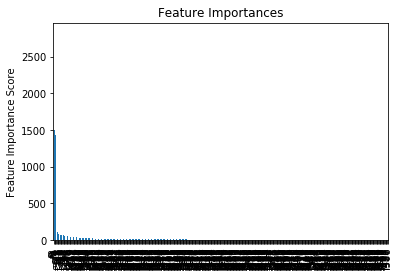

In [25]:
# #hyperparameter setting
# xgb1 = XGBClassifier(
#     learning_rate =0.1,
#     n_estimators=1000,
#     max_depth=5,
#     min_child_weight=1,
#     gamma=0,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27)
# modelfit(xgb1,X_train,y_train)

In [28]:
# param_grid = {
#     'learning_rate' :0.1,
#     'n_estimators':1000,
#     'max_depth':5,
#     'min_child_weight':1,
#     'gamma':0,
#     'subsample':0.8,
#     'colsample_bytree':0.8,
#     'objective': ['binary:logistic'],
#     'nthread':4,
#     'scale_pos_weight':1,
#     'seed':27
# }

# final = RandomizedSearchCV(estimator=xgb1,param_distributions = param_grid,cv=10)

In [32]:
# test_set_final.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,dep_delayed_15min,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,...,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,7,25,3,615,598,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,17,2,739,1235,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,2,7,651,577,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25,7,1614,377,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,6,3,1505,258,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# # final test_set
# test_set = test_set_final.drop('dep_delayed_15min',axis=1)

In [44]:
# print(list(test_set.columns))

['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_9E', 'UniqueCarrier_AA', 'UniqueCarrier_AQ', 'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO', 'UniqueCarrier_DH', 'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9', 'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO', 'UniqueCarrier_TZ', 'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN', 'UniqueCarrier_XE', 'UniqueCarrier_YV', 'Origin_ABE', 'Origin_ABI', 'Origin_ABQ', 'Origin_ABY', 'Origin_ACK', 'Origin_ACT', 'Origin_ACV', 'Origin_ACY', 'Origin_ADK', 'Origin_ADQ', 'Origin_AEX', 'Origin_AGS', 'Origin_AKN', 'Origin_ALB', 'Origin_ALO', 'Origin_AMA', 'Origin_ANC', 'Origin_APF', 'Origin_ASE', 'Origin_ATL', 'Origin_ATW', 'Origin_AUS', 'Origin_AVL', 'Origin_AVP', 'Origin_AZO', 'Origin_BDL', 'Origin_BET', 'Origin_BFL', 'Origin_BGM', 'Origin_BGR', 'Origin_BHM', 'Origin_BIL', 'Origin_BIS', 'Origin_BJI', 'Ori

In [42]:
# #convert object variables
# from sklearn import preprocessing
# lbl = preprocessing.LabelEncoder()
# test_set['Month'] = lbl.fit_transform(test_set['Month'].astype(str))
# test_set['DayofMonth'] = lbl.fit_transform(test_set['DayofMonth'].astype(str))
# test_set['DayOfWeek'] = lbl.fit_transform(test_set['DayOfWeek'].astype(str))

# print(test_set.dtypes)

Month         int32
DayofMonth    int32
DayOfWeek     int32
DepTime       int64
Distance      int64
              ...  
Dest_WYS      uint8
Dest_XNA      uint8
Dest_YAK      uint8
Dest_YKM      uint8
Dest_YUM      uint8
Length: 642, dtype: object


In [ ]:
#ideas
#feature engineering:
## time of the day, month, etc.
## PCA